In [ ]:
import logging
import hydra

import erc

logger = erc.utils.get_logger()

with hydra.initialize(version_base=None, config_path="./config"):
    cfg = hydra.compose(config_name="config",
                        overrides={"dataset._target_=erc.datasets.KEMDy19Dataset",
                                   "dataset.tokenizer_name=monologg/kobert" # change the tokenizer
                                   })
fold_num = 1
train_dataset = hydra.utils.instantiate(cfg.dataset,
                                        mode = "train",
                                        validation_fold = fold_num,
                                         )
valid_dataset = hydra.utils.instantiate(cfg.dataset,
                                        mode = "valid",
                                        validation_fold = fold_num,
                                         )


## Kobert 결과 
- name : monologg/kobert
- toekn : 8002

KoBert_tokenizer.decode(train_dataset[0]['txt'])
> '[CLS] 어 저 [UNK] 지금 사람 친 [UNK]? 지금 사람 친 거 [UNK]? [UNK]? [SEP]

## bert 결과 
- name : klue/bert-base
- token : 32000
Bert_tokenizer.decode(train_dataset[0]['txt'])
>  어 저 지그 지금 사람 친 거야? 지금 사람 친 거 맞지? 그치? 



긍/부정을 나누고 학습하는 것도 괜춘하긴 하네 ..
https://github.com/alswhddh/lyrics_emotion_analysis

In [ ]:
from transformers import AutoProcessor, AutoTokenizer
KoBert_tokenizer = AutoTokenizer.from_pretrained("monologg/kobert") 
KoBert_tokenizer

In [ ]:
KoBert_tokenizer.decode(train_dataset[0]['txt'])

In [ ]:
KoBert_tokenizer.decode(train_dataset[1]['txt'])

In [ ]:
KoBert_tokenizer.decode(train_dataset[2]['txt'])

In [ ]:
KoBert_tokenizer.decode(train_dataset[3]['txt'])

In [ ]:
# change torch dataset into huggingface dataset ... 
fold_num = 1
train_dataset = hydra.utils.instantiate(cfg.dataset, mode = "train", validation_fold = fold_num)
valid_dataset = hydra.utils.instantiate(cfg.dataset, mode = "valid", validation_fold = fold_num)

train_ds = erc.preprocess.generate_datasets(
    train_dataset,
    save_name = 'audio_dataset_19',
    mode  = 'train',
    validation_fold =fold_num,
    overrides=False
)
valid_ds = erc.preprocess.generate_datasets(
    valid_dataset,
    save_name = 'audio_dataset_19',
    mode  = 'valid',
    validation_fold =fold_num,
    overrides=False
)

In [ ]:
tokenizer.get_vocab()

## Bio-dataset

20과 19에 공통적으로 들어있는 `EDA` 와 `TEMP` 만을 사용한다.



In [1]:
from glob import glob
from tqdm.auto import tqdm
import numpy as np 
import pandas as pd


def generate_total(ANN_PATH):
    """total label, valence, arousal까지 불러오기"""
    M_ANN_PATH_fmt = "Session*_M_*"
    F_ANN_PATH_fmt = "Session*_F_*"

    except_dialogue = ["Sess01_impro03", "Sess01_impro04"]  # 나중에 테스트 빼기 쉽게...

    df_columns = [
        "Numb",
        "Wav_start",
        "Wav_end",
        "ECG_start",
        "ECG_end",
        "E4-EDA_start",
        "E4-EDA_end",
        "E4-TEMP_start",
        "E4-TEMP_end",
        "Segment ID",
        "Total Evaluation",
        "Arousal",
        "Valence",
        "dialogue_main",
    ]

    df = pd.DataFrame()
    for m_ann, f_ann in zip(
        sorted(glob(ANN_PATH + M_ANN_PATH_fmt)), sorted(glob(ANN_PATH + F_ANN_PATH_fmt))
    ):
        m_df = pd.read_csv(m_ann).iloc[:, :13].dropna()
        f_df = pd.read_csv(f_ann).iloc[:, :13].dropna()

        # Sess01_impro03, Sess01_impro04의 TEMP와 E4-EDA값이 결측
        m_df["dialogue_main"] = list(
            map(lambda x: "_".join(x.split("_")), m_df["Segment ID"])
        )
        f_df["dialogue_main"] = list(
            map(lambda x: "_".join(x.split("_")), f_df["Segment ID"])
        )
        m_df = m_df[~m_df["dialogue_main"].isin(except_dialogue)]
        f_df = f_df[~f_df["dialogue_main"].isin(except_dialogue)]

        # 각 발화의 성별에 대한 감정만 추출
        m_df = m_df[m_df["Segment ID"].str.contains("M")]
        f_df = f_df[f_df["Segment ID"].str.contains("F")]

        tmp = pd.concat([m_df, f_df], axis=0).sort_values("Numb")
        df = pd.concat([df,tmp], axis=0)

    df.columns = df_columns
    return df




In [2]:
def split_info(segment_id:str):
    session, script_type, speaker = segment_id.split("_")
    
    session_num = session[-2:]
    script_num = script_type[-2:]
    gender = speaker[0]
    # return session_num, script_num, gender
    return pd.Series([session_num, script_num, gender])


ANN_PATH = '/home/hoesungryu/etri-erc/data/KEMDy19/annotation/'
total_df = generate_total(ANN_PATH)
# total_df.head()

total_df = total_df[['Segment ID','Total Evaluation', 'Arousal', 'Valence']]
total_df[['session_num','script_num','gender']] = total_df['Segment ID'].apply(split_info)

In [3]:
total_df

,Segment ID,Total Evaluation,Arousal,Valence,session_num,script_num,gender
1,Sess01_script01_M001,surprise,1.7,4,01,01,M
2,Sess01_script01_F001,fear,1.5,3.6,01,01,F
3,Sess01_script01_M002,angry,1.3,4.3,01,01,M
4,Sess01_script01_M003,angry,1.5,3.8,01,01,M
5,Sess01_script01_F002,fear,1.6,3.7,01,01,F
...,...,...,...,...,...,...,...
513,Sess20_impro04_M018,sad,2.3,2.1,20,04,M
514,Sess20_impro04_F023,sad,2.5,2.3,20,04,F
515,Sess20_impro04_M019,sad,2.1,1.8,20,04,M
516,Sess20_impro04_F024,happy,3.9,3.2,20,04,F


In [4]:
def eda_preprocess(file_path):
    """ on_bad_line이 있어서 (column=4 or  3으로 일정하지 않아) 4줄로 통일 하는 함수 """
    columns = ["EDA_value", "a", "b", "Segment ID"]

    with open(file_path, "r") as f:
        lines = f.readlines()

    new_lines = []
    for line in lines:
    # for line in tqdm(lines):
        line = line.rstrip()
        if len(line.split(",")) <= 3:
            line += ",None"  # 4줄로 만들어주기 .
        new_lines.append(line.split(","))

    return pd.DataFrame(new_lines, columns=columns).replace("None", np.nan).dropna()

def extract_avg_diff(tmp : list, 
                     sub_num : int = 4):
    """
        divde into `sub_num` subset list and then get mean value from its subset 
    
    """
    subset_avg_diff = []
    sub_len = len(tmp)

    sub_set_idx = list(map(lambda x: int(x), np.linspace(0, sub_len, sub_num+1)))
    for idx in range(0,sub_num):
        mean_value = np.nanmean(tmp[sub_set_idx[idx]:sub_set_idx[idx+1]])
        subset_avg_diff.append(mean_value)

    sub_df = pd.Series(subset_avg_diff).to_frame().T
    sub_df.columns = [f'EDA_{i}stage' for i in range(1, sub_num+1)]
    return sub_df

In [54]:
EDA_19_PATH_FMT = "./data/KEMDy19/EDA/Session{0}/Original/Sess{0}{1}.csv"

pbar = tqdm(
    total=len(total_df), 
            iterable =total_df.iterrows() )

total_eda_df = pd.DataFrame()
# for idx, (df_info) in total_df.iterrows():
for idx, (df_info) in pbar:
    # print(idx, df_info)

    eda_sample_path = EDA_19_PATH_FMT.format(df_info['session_num'],df_info['gender'])
    unique_seg_id = df_info['Segment ID']
    # print(' ')
    # print(eda_sample_path)
    # print(unique_seg_id)

    eda_df = eda_preprocess(eda_sample_path)

    
    tmp = eda_df[eda_df['Segment ID']==unique_seg_id]['EDA_value'].astype(float).values
    avg_diff_df = extract_avg_diff(tmp, sub_num=2)
    avg_diff_df['Segment ID'] = unique_seg_id
    total_eda_df = pd.concat([total_eda_df, avg_diff_df])

    # pbar.update

    # break

  0%|          | 0/10197 [00:00<?, ?it/s]

/tmp/ipykernel_11869/4198972143.py:29: RuntimeWarning: Mean of empty slice
  mean_value = np.nanmean(tmp[sub_set_idx[idx]:sub_set_idx[idx+1]])
/tmp/ipykernel_11869/4198972143.py:29: RuntimeWarning: Mean of empty slice
  mean_value = np.nanmean(tmp[sub_set_idx[idx]:sub_set_idx[idx+1]])
/tmp/ipykernel_11869/4198972143.py:29: RuntimeWarning: Mean of empty slice
  mean_value = np.nanmean(tmp[sub_set_idx[idx]:sub_set_idx[idx+1]])
/tmp/ipykernel_11869/4198972143.py:29: RuntimeWarning: Mean of empty slice
  mean_value = np.nanmean(tmp[sub_set_idx[idx]:sub_set_idx[idx+1]])
/tmp/ipykernel_11869/4198972143.py:29: RuntimeWarning: Mean of empty slice
  mean_value = np.nanmean(tmp[sub_set_idx[idx]:sub_set_idx[idx+1]])
/tmp/ipykernel_11869/4198972143.py:29: RuntimeWarning: Mean of empty slice
  mean_value = np.nanmean(tmp[sub_set_idx[idx]:sub_set_idx[idx+1]])
/tmp/ipykernel_11869/4198972143.py:29: RuntimeWarning: Mean of empty slice
  mean_value = np.nanmean(tmp[sub_set_idx[idx]:sub_set_idx[idx+1]])

In [28]:
total_df = pd.merge(total_df[['Segment ID', 'Total Evaluation', 'Arousal', 'Valence', 'session_num',
       'script_num', 'gender']], total_eda_df.fillna(method='bfill', axis=0), on='Segment ID')
total_df.to_csv('../total_df_of_ead.csv',index=None)
# 161 정도 ... 


<Axes: >

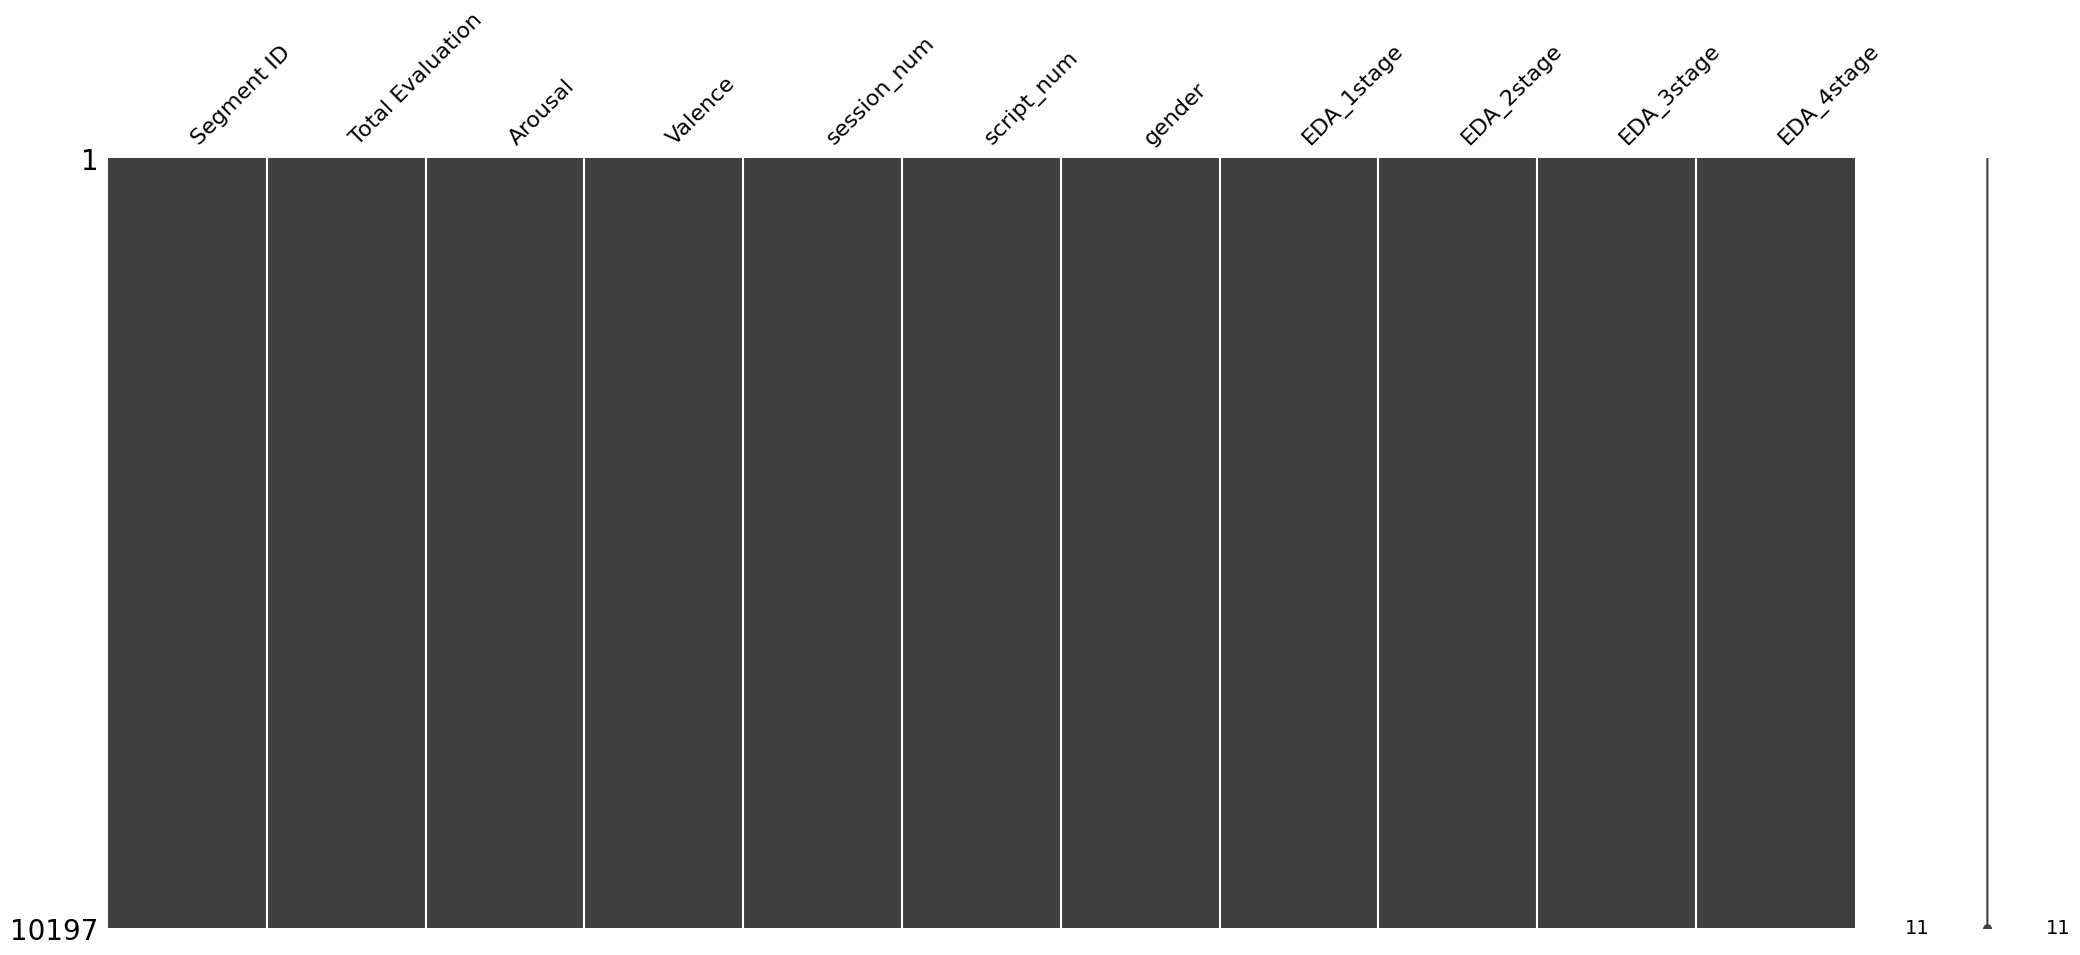

In [29]:
missingno.matrix(total_df)

In [30]:
eda_value = total_df[['EDA_1stage', 'EDA_2stage', 'EDA_3stage',
       'EDA_4stage']].values

In [31]:
# t-sne dimension reduction 
from sklearn.manifold import TSNE
tsne_np = TSNE(n_components = 2).fit_transform(eda_value)


In [32]:
tsne_df = pd.DataFrame(tsne_np, columns = ['component 0', 'component 1'])

In [33]:
df = pd.concat([total_df, tsne_df], axis=1)

In [34]:
df

,Segment ID,Total Evaluation,Arousal,Valence,session_num,script_num,gender,EDA_1stage,EDA_2stage,EDA_3stage,EDA_4stage,component 0,component 1
0,Sess01_script01_M001,surprise,1.7,4,01,01,M,4.354097,4.355639,4.451595,4.885545,64.862473,22.011616
1,Sess01_script01_F001,fear,1.5,3.6,01,01,F,0.144314,0.142714,0.142714,0.142074,-72.277435,45.967541
2,Sess01_script01_M002,angry,1.3,4.3,01,01,M,4.381857,4.410906,4.567074,4.913139,65.010536,21.816032
3,Sess01_script01_M003,angry,1.5,3.8,01,01,M,4.739891,4.704007,4.662998,4.612162,71.348885,21.643692
4,Sess01_script01_F002,fear,1.6,3.7,01,01,F,0.134821,0.132261,0.131407,0.130874,-79.212715,17.921312
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10192,Sess20_impro04_M018,sad,2.3,2.1,20,04,M,0.546180,0.546020,0.544578,0.538331,-6.987335,20.579811
10193,Sess20_impro04_F023,sad,2.5,2.3,20,04,F,0.220333,0.218440,0.217537,0.216090,-56.546707,-48.916512
10194,Sess20_impro04_M019,sad,2.1,1.8,20,04,M,0.517072,0.518719,0.513594,0.505447,-1.252680,5.753905
10195,Sess20_impro04_F024,happy,3.9,3.2,20,04,F,0.209741,0.209445,0.209051,0.207769,-58.274643,-38.586491


,Arousal,EDA_1stage,EDA_2stage,EDA_3stage,EDA_4stage
0,1.7,4.354097,4.355639,4.451595,4.885545
1,1.5,0.144314,0.142714,0.142714,0.142074
2,1.3,4.381857,4.410906,4.567074,4.913139
3,1.5,4.739891,4.704007,4.662998,4.612162
4,1.6,0.134821,0.132261,0.131407,0.130874
...,...,...,...,...,...
10192,2.3,0.546180,0.546020,0.544578,0.538331
10193,2.5,0.220333,0.218440,0.217537,0.216090
10194,2.1,0.517072,0.518719,0.513594,0.505447
10195,3.9,0.209741,0.209445,0.209051,0.207769


In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, r2_score
def get_accuracy(df, label = 'emotion', drop_col=[]):
        if len(drop_col) != 0:
                df = df.drop(drop_col, axis=1)

        X = df.drop([label],axis=1)
        y = df[label]

        model = RandomForestRegressor()
        predicted = cross_val_predict(model, X, y, cv=5)

        # acc = accuracy_score(y, predicted)
        # auc = roc_auc_score(y, predicted,average='weighted', multi_class='ovo')
        # f1 = f1_score(y, predicted, average='weighted')
        r2 = r2_score(y, predicted)
        # print(f'CV Acc: {acc:.4f}')
        # print(f'CV AUC: {auc:.4f}')
        print(f'CV R2: {r2:.4f}')
        print(' ')


In [ ]:
5-fold results with EDA data

Bio Arousal R2 : -0.1862
Bio Valence R2 : -0.1683
Bio Emtion ACC, F1 : 0.2637, 0.2271

In [42]:

print(get_accuracy(df[['Arousal', "EDA_1stage"	,"EDA_2stage","EDA_3stage","EDA_4stage"]], label='Arousal'))
# print(get_accuracy(df, label='emotion', drop_col='gender'))
# print(get_accuracy(df, label='gender'))

CV R2: -0.1862
 
None


In [44]:
print(get_accuracy(df[['Valence', "EDA_1stage"	,"EDA_2stage","EDA_3stage","EDA_4stage"]], label='Valence'))

CV R2: -0.1683
 
None


In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
def get_accuracy(df, label = 'emotion', drop_col=[]):
        if len(drop_col) != 0:
                df = df.drop(drop_col, axis=1)

        X = df.drop([label],axis=1)
        y = df[label]

        model = RandomForestClassifier()
        predicted = cross_val_predict(model, X, y, cv=5)

        acc = accuracy_score(y, predicted)
        # auc = roc_auc_score(y, predicted,average='weighted', multi_class='ovo')
        f1 = f1_score(y, predicted, average='weighted')

        print(f'CV Acc: {acc:.4f}')
        # print(f'CV AUC: {auc:.4f}')
        print(f'CV F1: {f1:.4f}')
        print(' ')

print(get_accuracy(df[['Total Evaluation', "EDA_1stage"	,"EDA_2stage","EDA_3stage","EDA_4stage"]], label='Total Evaluation'))


/home/hoesungryu/.conda/envs/erc/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


CV Acc: 0.2637
CV F1: 0.2271
 
None


/home/hoesungryu/.conda/envs/erc/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


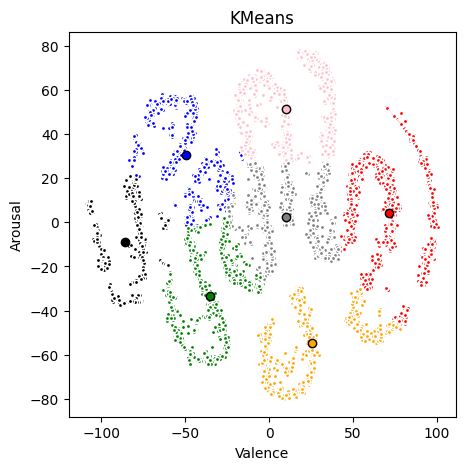

In [36]:
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans
colors = ['black', 'red', 'blue', 'orange', 'pink', 'grey', 'green']
values= tsne_np


kmeans_model = KMeans(n_clusters=7, random_state=0)
kmeans_model.fit(values)

k_means_labels = kmeans_model.predict(values)
k_means_cluster_centers = kmeans_model.cluster_centers_

fig, ax = plt.subplots(figsize=(5, 5))
for k, col in zip(range(7), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    ax.plot(values[my_members, 0], values[my_members, 1], 'w',
            markerfacecolor=col, marker='.')
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=6)
    
ax.set_title('KMeans')
ax.set_xlabel("Valence")
ax.set_ylabel("Arousal")
plt.show()

In [47]:
df

,Segment ID,Total Evaluation,Arousal,Valence,session_num,script_num,gender,EDA_1stage,EDA_2stage,EDA_3stage,EDA_4stage,component 0,component 1
0,Sess01_script01_M001,surprise,1.7,4,01,01,M,4.354097,4.355639,4.451595,4.885545,64.862473,22.011616
1,Sess01_script01_F001,fear,1.5,3.6,01,01,F,0.144314,0.142714,0.142714,0.142074,-72.277435,45.967541
2,Sess01_script01_M002,angry,1.3,4.3,01,01,M,4.381857,4.410906,4.567074,4.913139,65.010536,21.816032
3,Sess01_script01_M003,angry,1.5,3.8,01,01,M,4.739891,4.704007,4.662998,4.612162,71.348885,21.643692
4,Sess01_script01_F002,fear,1.6,3.7,01,01,F,0.134821,0.132261,0.131407,0.130874,-79.212715,17.921312
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10192,Sess20_impro04_M018,sad,2.3,2.1,20,04,M,0.546180,0.546020,0.544578,0.538331,-6.987335,20.579811
10193,Sess20_impro04_F023,sad,2.5,2.3,20,04,F,0.220333,0.218440,0.217537,0.216090,-56.546707,-48.916512
10194,Sess20_impro04_M019,sad,2.1,1.8,20,04,M,0.517072,0.518719,0.513594,0.505447,-1.252680,5.753905
10195,Sess20_impro04_F024,happy,3.9,3.2,20,04,F,0.209741,0.209445,0.209051,0.207769,-58.274643,-38.586491


In [48]:
df['Total Evaluation'].unique()

array(['surprise', 'fear', 'angry', 'neutral', 'neutral;fear',
       'angry;fear', 'happy', 'neutral;happy', 'neutral;surprise', 'sad',
       'neutral;angry', 'angry;surprise', 'disgust', 'neutral;disgust',
       'happy;surprise', 'neutral;sad', 'angry;disgust',
       'neutral;happy;angry', 'sad;fear', 'sad;angry', 'fear;surprise',
       'disgust;surprise', 'neutral;angry;disgust', 'angry;fear;surprise',
       'neutral;disgust;surprise', 'happy;angry', 'sad;surprise',
       'happy;fear', 'neutral;angry;fear', 'neutral;angry;surprise',
       'neutral;sad;surprise', 'neutral;fear;surprise',
       'neutral;happy;sad', 'neutral;happy;surprise',
       'neutral;happy;fear', 'neutral;sad;disgust', 'happy;sad',
       'happy;disgust', 'neutral;angry;fear;disgust;surprise',
       'fear;disgust', 'sad;disgust'], dtype=object)

In [51]:
tsne_df

,component 0,component 1,target
0,64.862473,22.011616,surprise
1,-72.277435,45.967541,fear
2,65.010536,21.816032,angry
3,71.348885,21.643692,angry
4,-79.212715,17.921312,fear
...,...,...,...
10192,-6.987335,20.579811,sad
10193,-56.546707,-48.916512,sad
10194,-1.252680,5.753905,sad
10195,-58.274643,-38.586491,happy


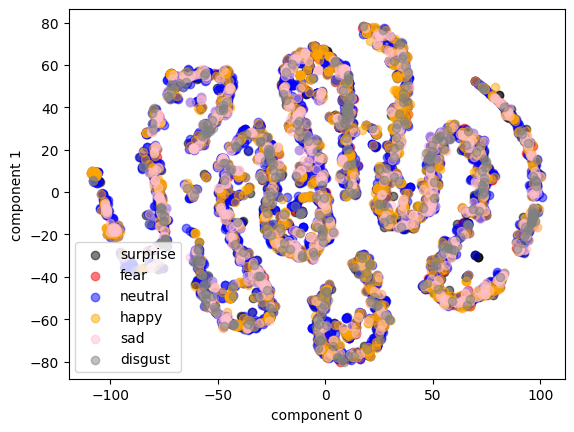

In [53]:
import matplotlib.pyplot as plt

# class target 정보 불러오기 
tsne_df['target'] = df['Total Evaluation']

# target 별 분리
tsne_df_0 = tsne_df[tsne_df['target'] == 'surprise']
tsne_df_1 = tsne_df[tsne_df['target'] == 'fear']
tsne_df_2 = tsne_df[tsne_df['target'] == 'neutral']
tsne_df_3 = tsne_df[tsne_df['target'] == 'happy']
tsne_df_4 = tsne_df[tsne_df['target'] == 'sad']
tsne_df_5 = tsne_df[tsne_df['target'] == 'disgust']



colors = ['black', 'red', 'blue', 'orange', 'pink', 'grey', 'green']
# target 별 시각화
plt.scatter(tsne_df_0['component 0'], tsne_df_0['component 1'], color = colors[0], alpha=0.5, label = 'surprise')
plt.scatter(tsne_df_1['component 0'], tsne_df_1['component 1'], color = colors[1], alpha=0.5, label = 'fear')
plt.scatter(tsne_df_2['component 0'], tsne_df_2['component 1'], color = colors[2], alpha=0.5, label = 'neutral')
plt.scatter(tsne_df_3['component 0'], tsne_df_3['component 1'], color = colors[3], alpha=0.5, label = 'happy')
plt.scatter(tsne_df_4['component 0'], tsne_df_4['component 1'], color = colors[4], alpha=0.5, label = 'sad')
plt.scatter(tsne_df_5['component 0'], tsne_df_5['component 1'], color = colors[5], alpha=0.5, label = 'disgust')

plt.xlabel('component 0')
plt.ylabel('component 1')
plt.legend()
plt.show()

In [ ]:



EDA_19_PATH_FMT = "./data/KEMDy19/EDA/Session{0}/Original/Sess{0}{1}.csv"

eda_sample_path = "./data/KEMDy19/EDA/Session20/Original/Sess20M.csv"
eda_df = eda_preprocess(eda_sample_path)
eda_df.head()

In [ ]:
eda_sample_path = "./data/KEMDy19/EDA/Session20/Original/Sess20F.csv"
eda_df = eda_preprocess(eda_sample_path)
eda_df.head()

In [ ]:
from collections import defaultdict

seg_id_ead = defaultdict(dict)

for unique_seg_id in eda_df['Segment ID'].unique():
    tmp = eda_df[eda_df['Segment ID']==unique_seg_id]['EDA_value'].values
    print(unique_seg_id)
    print(tmp)
    print(extract_avg_diff(tmp))
    seg_id_ead[unique_seg_id] = extract_avg_diff(tmp)
    break

In [ ]:
seg_id_ead

In [ ]:
sub_len = len(tmp)
sub_num = 5

sub_set_idx = list(map(lambda x: int(x), np.linspace(0, sub_len, sub_num)))

subset_avg_diff = []
for idx in range(0,sub_num-1):
    mean_value = np.mean(tmp[sub_set_idx[idx]:sub_set_idx[idx+1]])
    subset_avg_diff.append(mean_value)


In [ ]:
subset_avg_diff

In [ ]:
eda_df['EDA_value'] = eda_df['EDA_value'].astype(float)
tmp = eda_df[eda_df['Segment ID']=='Sess20_script01_M001']

In [ ]:
eda_df['EDA_value']

In [ ]:
len(tmp)

In [ ]:
int(len(tmp)/4)

In [ ]:
eda_df[eda_df['Segment ID']=='Sess20_script01_M001'].mean(axis=0)

In [ ]:
eda_df[eda_df['Segment ID']=='Sess20_script01_M001'].std(axis=0)

In [ ]:
train_dataset[0]

## Build Model

In [ ]:
# Wav2Vec2 
from transformers import AutoConfig, Wav2Vec2Processor
from erc.constants import idx2emotion, emotion2idx


# default value 
model_name_or_path = "kresnik/wav2vec2-large-xlsr-korean"
num_labels = 7 
pooling_mode = "mean" # max or min 

# set config
config = AutoConfig.from_pretrained(
    model_name_or_path,
    num_labels=num_labels,
    label2id=emotion2idx,
    id2label=idx2emotion,
    finetuning_task="wav2vec2_clf",
    pooling_mode = 'mean'
)

# setattr(config, 'pooling_mode', pooling_mode)

In [ ]:
from transformers import Wav2Vec2ForSequenceClassification

pretrained_model = Wav2Vec2ForSequenceClassification.from_pretrained(model_name_or_path, config=config)
processor= Wav2Vec2Processor.from_pretrained(model_name_or_path)

In [ ]:
from typing import Any, Dict, Union

import torch
from packaging import version
from torch import nn

from transformers import (
    Trainer,
    is_apex_available,
)

# if is_apex_available():
    # from apex import amp

# if version.parse(torch.__version__) >= version.parse("1.6"):
    # _is_native_amp_available = True

from torch.cuda import amp
from torch.cuda.amp import autocast


class CTCTrainer(Trainer):
    def training_step(self, model: nn.Module, inputs: Dict[str, Union[torch.Tensor, Any]]) -> torch.Tensor:
        """
        Perform a training step on a batch of inputs.

        Subclass and override to inject custom behavior.

        Args:
            model (:obj:`nn.Module`):
                The model to train.
            inputs (:obj:`Dict[str, Union[torch.Tensor, Any]]`):
                The inputs and targets of the model.

                The dictionary will be unpacked before being fed to the model. Most models expect the targets under the
                argument :obj:`labels`. Check your model's documentation for all accepted arguments.

        Return:
            :obj:`torch.Tensor`: The tensor with training loss on this batch.
        """

        model.train()
        inputs = self._prepare_inputs(inputs)

        # if self.use_amp:
        # with autocast():
            # loss = self.compute_loss(model, inputs)
        # else:
        loss = self.compute_loss(model, inputs)

        if self.args.gradient_accumulation_steps > 1:
            loss = loss / self.args.gradient_accumulation_steps

        # if self.use_amp:
        # self.scaler.scale(loss).backward()
        # elif self.use_apex:
        # with amp.scale_loss(loss, self.optimizer) as scaled_loss:
            # scaled_loss.backward()
        # elif self.deepspeed:
            # self.deepspeed.backward(loss)
        # else:
        loss.mean().backward()

        return loss.detach()


In [ ]:
from dataclasses import dataclass
from typing import Dict, List, Optional, Union
import torch

import transformers
from transformers import Wav2Vec2Processor


@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [feature["labels"] for feature in features]

        d_type = torch.long if isinstance(label_features[0], int) else torch.float

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )

        batch["labels"] = torch.tensor(label_features, dtype=d_type)

        return batch

In [ ]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

In [ ]:
import numpy as np
from transformers import EvalPrediction


def compute_metrics(p: EvalPrediction, is_regression = False):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.squeeze(preds) if is_regression else np.argmax(preds, axis=1)
    
    if is_regression:
        return {"mse": ((preds - p.label_ids) ** 2).mean().item()}
    else:
        return {"accuracy": (preds == p.label_ids).astype(np.float32).mean().item()}

In [ ]:
#  torch.cuda.set_device(2)

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./wav2vec2-xlsr-speech-emotion-classification",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    evaluation_strategy="steps",
    num_train_epochs=1.0,
    fp16=True,
    save_steps=10,
    eval_steps=10,
    logging_steps=10,
    learning_rate=1e-4,
    save_total_limit=2,
)

In [ ]:
# trainer = CTCTrainer(
#     model=pretrained_model,
#     # data_collator=data_collator,
#     args=training_args,
#     # compute_metrics=compute_metrics,
#     train_dataset=train_ds,
#     eval_dataset=valid_ds,
#     tokenizer= processor.feature_extractor,
# )

In [ ]:
from transformers import Trainer
trainer = Trainer(
    model=pretrained_model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=valid_ds,
    compute_metrics=compute_metrics,
    tokenizer= processor.feature_extractor,
)

In [ ]:
trainer.train()

In [ ]:

import torch
import torch.nn as nn 
import torch.nn.functional as F
from transformers import AdamW
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
import torch
from jiwer import wer # wer metircs 
from transformers import Wav2Vec2Processor
device = torch.device('cuda:1')

In [ ]:
# Pre-training Scheme ... 



# pretrain_str = "w11wo/wav2vec2-xls-r-300m-korean"


pretrained_model = Wav2Vec2ForSequenceClassification.from_pretrained(
    # "wav2vec2-xls-r-300m-korean",
    pretrain_str,
    num_labels=7
    )

In [ ]:
import erc

erc.utils.count_parameters(pretrained_model)

In [ ]:
model = pretrained_model.to(device)
# criterion = nn.MultiLabelSoftMarginLoss()
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr = 1e-5,  eps = 1e-8)

In [ ]:

total_loss = 0
train_acc_sum = 0
train_loss = []
for step, batch in enumerate(train_loader): 
    optimizer.zero_grad()
    labels = (batch['emotion']).to(device)
    input_values = processor(batch["wav"],
                             sampling_rate=16000,
                             return_tensors="pt",
                             return_attention_mask = False)['input_values'].squeeze()
    inputs = {"input_values":input_values,
              "attention_mask":batch['wav_mask'],
    }
    inputs = {key: inputs[key].to(device) for key in inputs}


    logits = model(**inputs).logits

    
    # outputs = torch.argmax(logits, dim=-1)
    # print(logi)

    loss = criterion(logits, labels.long())
    total_loss += loss.item()
    train_loss.append(total_loss/(step+1))
    # print(loss.item())
    loss.backward()
    optimizer.step()

avg_train_loss = total_loss / len(train_loader)
print(f'  Average training loss: {avg_train_loss:.2f}')



In [ ]:
print(logits.shape)
print(labels.shape)
print(labels.dtype)
print(logits.dtype)


In [ ]:
model.config.id2label

In [ ]:
torch.argmax(logits, dim=1)


In [ ]:
predicted_class_ids

In [ ]:
predicted_label = model.config.id2label[predicted_class_ids]

In [ ]:
predicted_label

In [ ]:


class EmotionClassfierWithAudio(nn.Module):
    def __init__(self,pretrained_model, n_classes=7):
        super().__init__()
        self.pretrianed_model = pretrained_model
        # for p in self.pretrianed_model.parameters():
            # p.requires_grad = False

        self.fc = nn.Linear(1025,n_classes)

    def forward(self, x):
        x = F.adaptive_avg_pool3d(self.pretrianed_model(x).logits , axis=1).squeeze()# mean of 355 // logit output shape: B, Seq(355), 1025
        x = self.fc(x)
        return x

In [ ]:
# !pip install jiwer
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
# import soundfile as sf
import torch
from jiwer import wer # wer metircs 
from transformers import Wav2Vec2Processor
batch = train_dataset[2]


processor = Wav2Vec2Processor.from_pretrained("kresnik/wav2vec2-large-xlsr-korean")
inputs = processor(batch["wav"], sampling_rate=16000, return_tensors="pt", return_attention_mask = False,
                #    padding="longest"
                   )

In [ ]:
inputs.keys()

In [ ]:
inputs['input_values']

In [ ]:
batch.keys()

In [ ]:
batch['wav']

In [ ]:
batch['wav_mask']

In [ ]:
batch['wav_mask'].shape

In [ ]:
inputs['attention_mask'].squeeze()


In [ ]:
inputs['attention_mask'].shape

In [ ]:



model = Wav2Vec2ForCTC.from_pretrained("kresnik/wav2vec2-large-xlsr-korean").to('cuda')

input_values = inputs.input_values
print(input_values.shape)
with torch.no_grad():
    logits = model(input_values.type(torch.FloatTensor).to("cuda")).logits
predicted_ids = torch.argmax(logits, dim=-1)
transcription = processor.batch_decode(predicted_ids)
print(batch['txt'])
print(transcription)
print("WER:", wer(batch['txt'], transcription))

In [ ]:
logits.shape

In [ ]:
logits[:,-1].shape

In [ ]:
logits.shape

In [ ]:
logits.mean(axis=1).shape

In [ ]:
logits[:,-1]

In [ ]:
logits

In [ ]:
logits

In [ ]:
model(input_values.type(torch.FloatTensor).to("cuda"))

In [ ]:
predicted_ids